# Optimizing Tensor Computation Graphs with Equality Saturation and Monte Carlo Tree Search

This notebook can be used to process and visualize the experimental results of our paper. Before continuing with the notebook, please make sure that you have run the necessary experiments as described in the README file of the repository. If the experiments have been run successfully, it should be sufficient to change the base paths in the respective cells of the notebook to the paths of the experiment directories on your machine. Afterwards, you should be able to run the notebook from top to bottom and generate the plots and tables that are included in the paper. Please note that the hardware, stochastic nature of the cost model, and the randomness of MCTS can lead to slight variations in the results.

Please make sure that you have installed the necessary dependencies by running `pip install -r requirements.txt`.

In [1]:
# Imports
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing

## Settings

In [2]:
# MCTS settings
base_path_mcts = './tensor_eqs_mcts'

# Different combinations of main and final extraction method
experiments = ['egg_greedy_egg_greedy', 'egg_greedy_tensat_ilp', 'new_greedy_new_greedy', 'new_greedy_tensat_ilp', 'tensat_ilp_tensat_ilp']

In [3]:
# TENSAT settings
base_path_tensat = './tensat'

#k_multi
model_multi_iter = {
    'bert': 1,
    'inceptionv3': 2,
    'mobilenetv2': 1,
    'nasneta': 1,
    'nasrnn': 3,
    'resnet50': 4,
    'resnext50': 4,
    'squeezenet': 3,
    'vgg': 1
}

In [4]:
# General settings

# Models
models = ['bert', 'inceptionv3', 'resnext50', 'nasneta', 'vgg', 'mobilenetv2', 'resnet50', 'squeezenet', 'nasrnn']
model_names = {
    'bert': 'BERT', 
    'inceptionv3': 'Inception-v3', 
    'mobilenetv2': 'MobileNet-v2', 
    'nasneta': 'NASNet-A', 
    'nasrnn': 'NASRNN', 
    'resnet50': 'ResNet-50', 
    'resnext50': 'ResNeXt-50', 
    'squeezenet': 'SqueezeNet', 
    'vgg': 'VGG-19'
}

# Seeds
num_seeds = 5

# Rules
num_single_rewrite_rules = 124
num_multi_rewrite_rules = 15
num_rules = num_single_rewrite_rules + num_multi_rewrite_rules

## MCTS Data

In [5]:
# Extraction methods
df_mcts = pd.DataFrame(columns = ['seed', 'model', 'experiment', 'extraction', 'final_extraction', 'rmcts_base_cost', 'rmcts_final_cost', 'rmcts_original_runtime', 'rmcts_optimized_runtime', 'rmcts_optimization_time'])

# Iteration data
df_iter = pd.DataFrame(columns = ['model', 'iteration', 'action', 'base_cost', 'best_cost', 'done', 'episode_reward', 'planning_time', 'reward', 'runner_apply_time', 'runner_egraph_classes', 'runner_egraph_nodes', 'runner_iterations', 'runner_memo_size', 'runner_rebuild_time', 'runner_rebuilds', 'runner_search_time', 'runner_stop_reason', 'runner_total_time', 'total_planning_time'])

# Rules data
df_mcts_rules = pd.DataFrame(columns = ['Experiment', 'Seed', 'Model', 'Rule', 'Applied'])

# Stats data
df_stats = pd.DataFrame(columns = ['model', 'base_cost', 'final_cost', 'optimized_runtime', 'original_runtime'])

In [6]:
# Preprocessing
for experiment in experiments:
    for model in models:
        for seed in range(0, 5):
            output_dir = os.path.join(base_path_mcts, experiment, model + '_' + str(seed))
            
            try:
                # Load settings
                filename = os.path.join(output_dir, 'settings.txt')
                with open(filename, 'r') as file:
                    settings = file.read().rstrip()
                settings = json.loads(settings)

                extraction = settings['extraction']
                final_extraction = settings['final_extraction']

                # Load iteration and rules data
                filename = os.path.join(output_dir, 'rmcts_iteration_data.txt')
                with open(filename) as f:
                    iteration_data = f.read().splitlines()
                
                applied_rules = {}
                for i, iteration in enumerate(iteration_data):
                    iteration = json.loads(iteration)
                    df_iter.loc[len(df_iter.index)] = {'model': model, 'iteration': i} | iteration

                    rule = iteration['action']
                    applied_rules[rule] = applied_rules.get(rule, 0) + 1

                for rule, count in applied_rules.items():
                    df_mcts_rules.loc[len(df_mcts_rules.index)] = [experiment, seed, model_names[model], rule, count]

                # Load rmcts stats
                filename = os.path.join(output_dir, 'rmcts_stats.txt')
                with open(filename, 'r') as file:
                    rmcts_stats = file.read().rstrip()
                rmcts_stats = json.loads(rmcts_stats)

                new_datapoint = [seed, model_names[model], experiment, extraction, final_extraction, rmcts_stats['base_cost'], rmcts_stats['final_cost'], rmcts_stats['original_runtime'], rmcts_stats['optimized_runtime'], rmcts_stats['optimization_time']]
            except Exception as e:
                print("Exception! Experiment: ", experiment, ", model: ", model, ", seed: ", seed, ". Error message: ", e)
                new_datapoint = [seed, model_names[model], experiment, extraction, final_extraction, np.nan, np.nan, np.nan, np.nan, np.nan]
            
            df_mcts.loc[len(df_mcts.index)] = new_datapoint

In [7]:
# Calculate the speedup between the original and optimized runtime for each run
df_mcts['speedup'] = (df_mcts['rmcts_original_runtime'] - df_mcts['rmcts_optimized_runtime']) / df_mcts['rmcts_original_runtime'] * 100

# Make a copy of the dataframe for later
df_extraction = df_mcts.copy()

# Add approach column
df_mcts['approach'] = 'MCTS'

# Drop experiment, rmcts_base_cost, rmcts_final_cost columns
df_mcts = df_mcts.drop(columns=['experiment', 'rmcts_base_cost', 'rmcts_final_cost'])

# Rename rmcts_original_runtime to original_runtime, rmcts_optimized_runtime to optimized_runtime, and rmcts_optimization_time to optimization_time
df_mcts = df_mcts.rename(columns={'rmcts_original_runtime': 'original_runtime', 'rmcts_optimized_runtime': 'optimized_runtime', 'rmcts_optimization_time': 'optimization_time'})

## TENSAT Data

In [8]:
# General statistics
df_tensat = pd.DataFrame(columns = ['seed', 'model', 'multi_iter', 'tensat_original_runtime', 'tensat_optimized_runtime', 'tensat_optimization_time'])

# Iteration data
df_iter = pd.DataFrame(columns = ['model', 'iteration', 'egraph_nodes', 'egraph_classes', 'applied', 'applied_rules', 'hook_time', 'search_time', 'apply_time', 'rebuild_time', 'total_time', 'data', 'n_rebuilds', 'stop_reason', 'num_single_rules_applied', 'num_multi_rules_applied'])

# Rules (matches) dataframes
df_tensat_rules = pd.DataFrame(columns = ['Seed', 'Model', 'Rule', 'Applied', 'Matches applied'])

# Statistics dataframe
df_stats = pd.DataFrame(columns = ['model', 'iter_multi', 'runner_stop_reason', 'runner_time', 'num_iterations', 'num_enodes', 'num_classes', 'avg_nodes_per_class', 'num_edges', 'num_programs', 'extraction_time', 'original_runtime', 'optimized_runtime'])

In [9]:
# Preprocessing
for model in models:
    for seed in range(num_seeds):
        multi_iter = model_multi_iter[model]
        output_dir = os.path.join(base_path_tensat, model + '_' + str(multi_iter) + '_' + str(seed))
        
        # Load settings
        filename = os.path.join(output_dir, 'settings.txt')
        with open(filename, 'r') as file:
            settings = file.read().rstrip()
        settings = json.loads(settings)

        # Load settings
        filename = os.path.join(output_dir, 'stats.txt')
        with open(filename, 'r') as file:
            tensat_stats = file.read().rstrip()
        tensat_stats = json.loads(tensat_stats)

        new_datapoint = [seed, model, multi_iter, tensat_stats['original_runtime'], tensat_stats['optimized_runtime'], tensat_stats['runner_time'] + tensat_stats['extraction_time']]
        df_tensat.loc[len(df_tensat.index)] = new_datapoint

        # Get important settings
        model = settings['model']
        iter_multi = settings['iter_multi']


        ### (Hook) iteration data ###
        filename = os.path.join(output_dir, 'iteration_data.txt')
        with open(filename, 'r') as file:
            iteration_data = file.read().rstrip()
        iteration_data = json.loads(iteration_data)

        filename = os.path.join(output_dir, 'hook_iteration_data.txt')
        with open(filename) as f:
            hook_iteration_data = f.read().splitlines()

        # Create iteration dataframe and rewrite rules
        applied_rules = {}
        applied_rules_matches = {}
        for i, iteration in enumerate(iteration_data):
            applied_rules_in_this_iteration = {}

            # Single rewrite rules
            num_single_rewrite_rule_matches = 0
            for rule, count in iteration['applied'].items():
                rule = int(rule[4:])
                applied_rules[rule] = applied_rules.get(rule, 0) + 1
                applied_rules_in_this_iteration[rule] = applied_rules_in_this_iteration.get(rule, 0) + 1
                applied_rules_matches[rule] = applied_rules_matches.get(rule, 0) + count
                num_single_rewrite_rule_matches += count

            # Multi-pattern rewrite rules
            num_multi_rewrite_rules = 0
            hook = json.loads(hook_iteration_data[i])
            for rule, count in hook.items():
                rule = int(rule)
                if count == 0:
                    continue
                rule += num_single_rewrite_rules
                applied_rules[rule] = applied_rules.get(rule, 0) + 1
                applied_rules_in_this_iteration[rule] = applied_rules_in_this_iteration.get(rule, 0) + 1
                applied_rules_matches[rule] = applied_rules_matches.get(rule, 0) + count
                num_multi_rewrite_rules += count

            df_iter.loc[len(df_iter.index)] = {'model': model, 'iteration': i, 'applied_rules': applied_rules_in_this_iteration, 'num_single_rules_applied': num_single_rewrite_rule_matches, 'num_multi_rules_applied': num_multi_rewrite_rules} | iteration


        ### Fill rules (matches) dataframes ###
        for rule, count in applied_rules.items():
            df_tensat_rules.loc[len(df_tensat_rules.index)] = [seed, model_names[model], rule, count, applied_rules_matches[rule]]

        
        ### Statistics ###
        filename = os.path.join(output_dir, 'stats.txt')
        with open(filename, 'r') as file:
            statistics_data = file.read().rstrip()
        statistics_data = json.loads(statistics_data)
        df_stats.loc[len(df_stats.index)] = {'model': model, 'iter_multi': iter_multi} | statistics_data

In [10]:
# Calculate the speedup between the original and optimized runtime for each run
df_tensat['speedup'] = (df_tensat['tensat_original_runtime'] - df_tensat['tensat_optimized_runtime']) / df_tensat['tensat_original_runtime'] * 100

# Add approach column
df_tensat['approach'] = 'TENSAT'

# Rename tensat_original_runtime to original_runtime, tensat_optimized_runtime to optimized_runtime, and tensat_optimization_time to optimization_time
df_tensat = df_tensat.rename(columns={'tensat_original_runtime': 'original_runtime', 'tensat_optimized_runtime': 'optimized_runtime', 'tensat_optimization_time': 'optimization_time'})

# Add extraction column and set it to None
df_tensat['extraction'] = 'None'

# Add final_extraction column and set to 'ILP'
df_tensat['final_extraction'] = 'ILP'

# Drop multi_iter column
df_tensat = df_tensat.drop(columns=['multi_iter'])

# Rename models
df_tensat['model'] = df_tensat['model'].map(model_names)

# Reproduce Experimental Results

## Table 2 (Appendix)

In [11]:
# Combine the two dataframes
df_combined = pd.concat([df_mcts, df_tensat])

# Groupby model, approach, extraction, final_extraction and calculate mean and std
comprehensive_comparison = df_combined[['model', 'approach', 'extraction', 'final_extraction', 'original_runtime', 'optimized_runtime', 'optimization_time', 'speedup']].groupby(by = ['model', 'approach', 'extraction', 'final_extraction']).agg(['mean', 'std']).round(2)

# Reindex the dataframe
comprehensive_comparison = comprehensive_comparison.reset_index()

# Rename columns
comprehensive_comparison = comprehensive_comparison.rename(columns = {'model': 'Model', 'approach': 'Approach', 'extraction': 'Main extraction', 'final_extraction': 'Final extraction', 'original_runtime': 'Original runtime (ms)', 'optimized_runtime': 'Optimized runtime (ms)', 'optimization_time': 'Optimization time (s)', 'speedup': 'Runtime speedup (%)'})

# Switch the last two columns
comprehensive_comparison = comprehensive_comparison[['Model', 'Approach', 'Main extraction', 'Final extraction', 'Original runtime (ms)', 'Optimized runtime (ms)', 'Runtime speedup (%)', 'Optimization time (s)']]

# In Main extraction and Final extraction, replace "egg_greedy" with "Default greedy", "new_greedy" with "Our greedy", and "tensat_ilp" with "ILP"
comprehensive_comparison['Main extraction'] = comprehensive_comparison['Main extraction'].replace({'egg_greedy': 'Default greedy', 'new_greedy': 'Our greedy', 'tensat_ilp': 'ILP'})
comprehensive_comparison['Final extraction'] = comprehensive_comparison['Final extraction'].replace({'egg_greedy': 'Default greedy', 'new_greedy': 'Our greedy', 'tensat_ilp': 'ILP'})

# Swap rows 30-35 (ResNeXt-50) with 36-41 (ResNet-50)
comprehensive_comparison = comprehensive_comparison.reindex([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 36, 37, 38, 39, 40, 41, 30, 31, 32, 33, 34, 35, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53])
comprehensive_comparison = comprehensive_comparison.reset_index(drop=True)

In [12]:
comprehensive_comparison

Model Approach Main extraction Final extraction  \
                                                             
0           BERT     MCTS  Default greedy   Default greedy   
1           BERT     MCTS  Default greedy              ILP   
2           BERT     MCTS      Our greedy       Our greedy   
3           BERT     MCTS      Our greedy              ILP   
4           BERT     MCTS             ILP              ILP   
5           BERT   TENSAT            None              ILP   
6   Inception-v3     MCTS  Default greedy   Default greedy   
7   Inception-v3     MCTS  Default greedy              ILP   
8   Inception-v3     MCTS      Our greedy       Our greedy   
9   Inception-v3     MCTS      Our greedy              ILP   
10  Inception-v3     MCTS             ILP              ILP   
11  Inception-v3   TENSAT            None              ILP   
12  MobileNet-v2     MCTS  Default greedy   Default greedy   
13  MobileNet-v2     MCTS  Default greedy              ILP   
14  MobileNet-v2     MCTS      Our greedy       Our greedy   
15  MobileNet-v2     MCTS      Our greedy              ILP   
16  MobileNet-v2     MCTS             ILP              ILP   
17  MobileNet-v2   TENSAT            None              ILP   
18      NASNet-A     MCTS  Default greedy   Default greedy   
19      NASNet-A     MCTS  Default greedy              ILP   
20      NASNet-A     MCTS      Our greedy       Our greedy   
21      NASNet-A     MCTS      Our greedy              ILP   
22      NASNet-A     MCTS             ILP              ILP   
23      NASNet-A   TENSAT            None              ILP   
24        NASRNN     MCTS  Default greedy   Default greedy   
25        NASRNN     MCTS  Default greedy              ILP   
26        NASRNN     MCTS      Our greedy       Our greedy   
27        NASRNN     MCTS      Our greedy              ILP   
28        NASRNN     MCTS             ILP              ILP   
29        NASRNN   TENSAT            None              ILP   
30     ResNet-50     MCTS  Default greedy   Default greedy   
31     ResNet-50     MCTS  Default greedy              ILP   
32     ResNet-50     MCTS      Our greedy       Our greedy   
33     ResNet-50     MCTS      Our greedy              ILP   
34     ResNet-50     MCTS             ILP              ILP   
35     ResNet-50   TENSAT            None              ILP   
36    ResNeXt-50     MCTS  Default greedy   Default greedy   
37    ResNeXt-50     MCTS  Default greedy              ILP   
38    ResNeXt-50     MCTS      Our greedy       Our greedy   
39    ResNeXt-50     MCTS      Our greedy              ILP   
40    ResNeXt-50     MCTS             ILP              ILP   
41    ResNeXt-50   TENSAT            None              ILP   
42    SqueezeNet     MCTS  Default greedy   Default greedy   
43    SqueezeNet     MCTS  Default greedy              ILP   
44    SqueezeNet     MCTS      Our greedy       Our greedy   
45    SqueezeNet     MCTS      Our greedy              ILP   
46    SqueezeNet     MCTS             ILP              ILP   
47    SqueezeNet   TENSAT            None              ILP   
48        VGG-19     MCTS  Default greedy   Default greedy   
49        VGG-19     MCTS  Default greedy              ILP   
50        VGG-19     MCTS      Our greedy       Our greedy   
51        VGG-19     MCTS      Our greedy              ILP   
52        VGG-19     MCTS             ILP              ILP   
53        VGG-19   TENSAT            None              ILP   

   Original runtime (ms)       Optimized runtime (ms)        \
                    mean   std                   mean   std   
0                   1.32  0.00                   1.32  0.00   
1                   1.32  0.00                   1.30  0.00   
2                   1.32  0.00                   1.32  0.00   
3                   1.32  0.00                   1.13  0.15   
4                   1.32  0.00                   0.87  0.00   
5                   1.32  0.00                   1.03  0.00   
6                  15.58  1.14    

## Figure 5

In [13]:
# Aggregate across seeds
df_extraction = df_extraction[['model', 'experiment', 'extraction', 'final_extraction', 'rmcts_original_runtime', 'rmcts_optimized_runtime', 'rmcts_optimization_time', 'speedup']].groupby(by = ['model', 'experiment', 'extraction', 'final_extraction']).agg(['mean', 'std']).round(2)

# Aggregate across experiments
df_extraction = df_extraction[['rmcts_original_runtime', 'rmcts_optimized_runtime', 'rmcts_optimization_time', 'speedup']].groupby(by = ['experiment']).agg(['mean', 'std']).round(2)

# Rename the experiments
df_extraction = df_extraction.rename(index = {'egg_greedy_egg_greedy': 'DCF / DCF', 'egg_greedy_tensat_ilp': 'DCF / ILP', 'new_greedy_new_greedy': 'OCF / OCF', 'new_greedy_tensat_ilp': 'OCF / ILP', 'tensat_ilp_tensat_ilp': 'ILP / ILP'})

# Reindex
df_extraction = df_extraction.reindex(['DCF / DCF', 'DCF / ILP', 'OCF / OCF', 'OCF / ILP', 'ILP / ILP'])

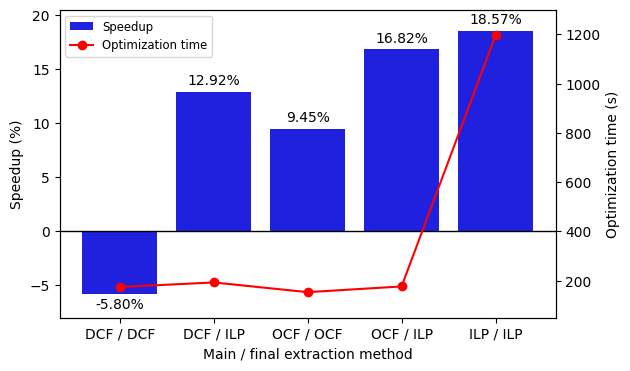

In [14]:
# Plot the percentage speedup in a bar chart for each experiment
plt.figure(figsize=(6.40, 4))
ax = sns.barplot(x=df_extraction.index, 
                 y=df_extraction['speedup']['mean']['mean'], 
                 color='blue')

ax.set_xlabel("Main / final extraction method")
ax.set_ylabel("Speedup (%)")
# Insert horizontal lines
ax.axhline(0, color='black', linewidth=1)

# Add percentage values above the bars
for i, p in enumerate(ax.patches):
    xytext = (0, -8) if i == 0 else (0, 8)
    ax.annotate("{:.2f}%".format(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=xytext, textcoords='offset points')

# Add line plot for the optimization time
ax2 = ax.twinx()
line, = ax2.plot(df_extraction['rmcts_optimization_time']['mean']['mean'], 
                 marker='o', color='red', linestyle='solid', label='Optimization time (s)')

ax2.set_ylabel("Optimization time (s)")

# Set the y-axis limits
ax.set_ylim([-8, 20.5])
ax2.set_ylim([50, 1300])

# Combine legends
bars = ax.patches[0]
legend_elements = [bars, line]
ax2.legend(legend_elements, ['Speedup', 'Optimization time'], loc='upper left', fontsize='small')

plt.show()

## Figure 6

In [15]:
# Prepare data
tensat_speedup_mean = comprehensive_comparison[comprehensive_comparison['Approach'] == 'TENSAT']['Runtime speedup (%)']['mean']
tensat_speedup_std = comprehensive_comparison[comprehensive_comparison['Approach'] == 'TENSAT']['Runtime speedup (%)']['std']

mcts_ocf_ilp_speedup_mean = comprehensive_comparison[(comprehensive_comparison['Approach'] == 'MCTS') & (comprehensive_comparison['Main extraction'] == 'Our greedy') & (comprehensive_comparison['Final extraction'] == 'ILP')]['Runtime speedup (%)']['mean']
mcts_ocf_ilp_speedup_std = comprehensive_comparison[(comprehensive_comparison['Approach'] == 'MCTS') & (comprehensive_comparison['Main extraction'] == 'Our greedy') & (comprehensive_comparison['Final extraction'] == 'ILP')]['Runtime speedup (%)']['std']

mcts_ilp_ilp_speedup_mean = comprehensive_comparison[(comprehensive_comparison['Approach'] == 'MCTS') & (comprehensive_comparison['Main extraction'] == 'ILP') & (comprehensive_comparison['Final extraction'] == 'ILP')]['Runtime speedup (%)']['mean']
mcts_ilp_ilp_speedup_std = comprehensive_comparison[(comprehensive_comparison['Approach'] == 'MCTS') & (comprehensive_comparison['Main extraction'] == 'ILP') & (comprehensive_comparison['Final extraction'] == 'ILP')]['Runtime speedup (%)']['std']

model_order = ['BERT', 'Inception-v3', 'MobileNet-v2', 'NASNet-A', 'NASRNN', 'ResNet-50', 'ResNeXt-50', 'SqueezeNet', 'VGG-19']

means = [
    tensat_speedup_mean,
    mcts_ocf_ilp_speedup_mean,
    mcts_ilp_ilp_speedup_mean
]
stds = [
    tensat_speedup_std,
    mcts_ocf_ilp_speedup_std,
    mcts_ilp_ilp_speedup_std
]

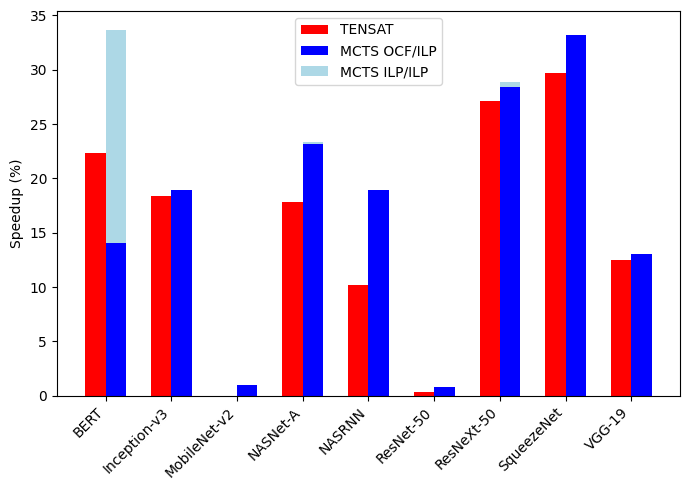

In [16]:
# Plotting
fig, ax = plt.subplots(figsize=(7, 5))

bar_width = 0.31
index = np.arange(len(model_order))

colors = ['red', 'blue', 'lightblue']  # Colors for bars

for i in range(len(means) - 1, -1, -1):
    if i == 2:
        ax.bar(index + (i - 1) * bar_width, means[i], bar_width, label=f'Method {i+1}', capsize=5, color=colors[i], alpha=1)
    else:
        ax.bar(index + i * bar_width, means[i], bar_width, label=f'Method {i+1}', capsize=5, color=colors[i])

ax.set_ylabel('Speedup (%)')
ax.set_xticks(index + (bar_width / 2))
ax.set_xticklabels(model_order, rotation=45, ha='right')
ax.legend(['TENSAT', 'MCTS OCF/ILP', 'MCTS ILP/ILP'])
for handle, color in zip(ax.get_legend().legend_handles, colors):
    handle.set_facecolor(color)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

## Figure 7

In [17]:
# Filter df_tensat_rules dataframe for any seed (TENSAT's rule selection is deterministic)
df_rules = df_tensat_rules[df_tensat_rules['Seed'] == 0]

# Filter out the dummy action
df_rules_wo_dummy_action = df_rules.loc[df_rules['Rule'] != 18_446_744_073_709_551_615]
df_rules_wo_dummy_action.Rule = df_rules_wo_dummy_action.Rule.astype(int)

[]

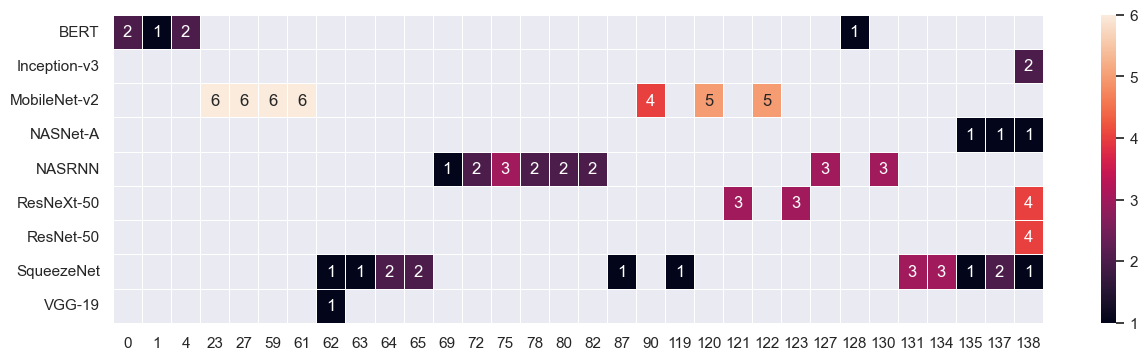

In [20]:
# Run this cell twice to get a nice background

# Create rules pivot table
df_rules_applied = df_rules_wo_dummy_action.pivot(index = "Model", columns = "Rule", values = "Applied")

# Plot rewrite rules heatmap
fig, ax = plt.subplots(figsize = (15, 4))
sns.set_theme(style = 'dark')
sns.heatmap(df_rules_applied, annot = True, linewidth = 0.5, ax = ax, fmt = '.0f', cbar_kws = {"ticks":[1, 2, 3, 4, 5, 6, 7]})
# ax.set_title("RMCTS")
# Remove the x-axis and y-axis labels
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
plt.plot()

## Figure 8

In [21]:
# Filter df_mcts_rules dataframe for Experiment = 'tensat_ilp_tensat_ilp' and seed = 4
df_rules = df_mcts_rules[(df_mcts_rules['Experiment'] == 'tensat_ilp_tensat_ilp') & (df_mcts_rules['Seed'] == 4)]

# Filter out the dummy action
df_rules_wo_dummy_action = df_rules.loc[df_rules['Rule'] != 18_446_744_073_709_551_615]
df_rules_wo_dummy_action.Rule = df_rules_wo_dummy_action.Rule.astype(int)

/var/folders/nw/yxlw03097hq4vgclj6npgr2r0000gn/T/ipykernel_50584/1931253575.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rules_wo_dummy_action.Rule = df_rules_wo_dummy_action.Rule.astype(int)


[]

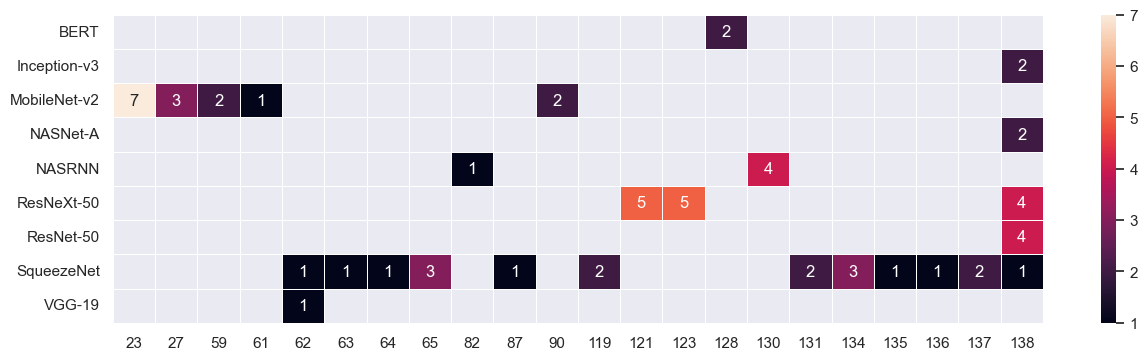

In [22]:
# Create rules pivot table
df_rules_applied = df_rules_wo_dummy_action.pivot(index = "Model", columns = "Rule", values = "Applied")

# Plot rewrite rules heatmap
fig, ax = plt.subplots(figsize = (15, 4))
sns.set_theme(style = 'dark')
sns.heatmap(df_rules_applied, annot = True, linewidth = 0.5, ax = ax, fmt = '.0f', cbar_kws = {"ticks":[1, 2, 3, 4, 5, 6, 7]})
# ax.set_title("RMCTS")
# Remove the x-axis and y-axis labels
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
plt.plot()

## Figure 10 (Appendix)

In [23]:
# Filter df_mcts_rules dataframe for Experiment = 'new_greedy_tensat_ilp' and seed = 3
df_rules = df_mcts_rules[(df_mcts_rules['Experiment'] == 'new_greedy_tensat_ilp') & (df_mcts_rules['Seed'] == 3)]

# Filter out the dummy action
df_rules_wo_dummy_action = df_rules.loc[df_rules['Rule'] != 18_446_744_073_709_551_615]
df_rules_wo_dummy_action.Rule = df_rules_wo_dummy_action.Rule.astype(int)

/var/folders/nw/yxlw03097hq4vgclj6npgr2r0000gn/T/ipykernel_50584/170896474.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rules_wo_dummy_action.Rule = df_rules_wo_dummy_action.Rule.astype(int)


[]

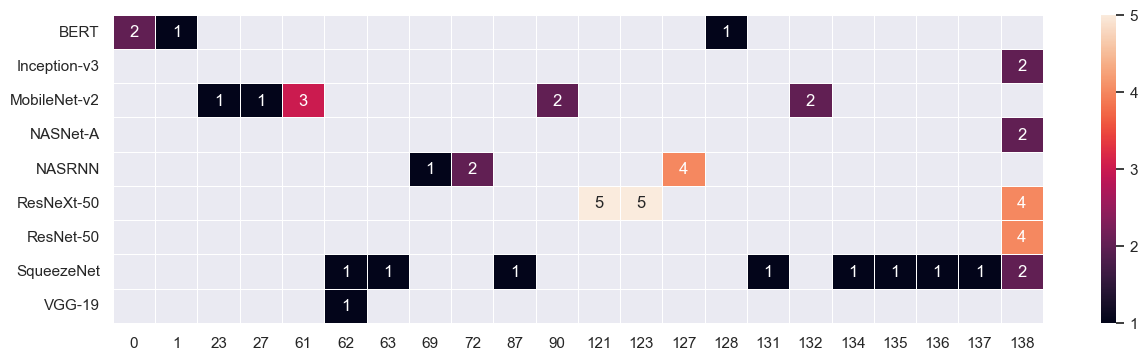

In [24]:
# Create rules pivot table
df_rules_applied = df_rules_wo_dummy_action.pivot(index = "Model", columns = "Rule", values = "Applied")

# Plot rewrite rules heatmap
fig, ax = plt.subplots(figsize = (15, 4))
sns.set_theme(style = 'dark')
sns.heatmap(df_rules_applied, annot = True, linewidth = 0.5, ax = ax, fmt = '.0f', cbar_kws = {"ticks":[1, 2, 3, 4, 5, 6, 7]})
# ax.set_title("RMCTS")
# Remove the x-axis and y-axis labels
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
plt.plot()